# Wordle!

#### Authors:
v1.0 (Fall 2022): Andy Dong

## Setup
This version of the lab is designed to run locally on your machine. Please do not use JupyterHub to run this version as the lab requires more memory than allowed by JupyterHub. If you are unable to run this lab locally, please check out the Google Colab version.

## Introduction

In the game of [Wordle](https://www.nytimes.com/games/wordle/index.html), your goal is to deduce a 5-letter secret word that the game has generated using as few guesses as possible. After each guess, the game will tell you for each letter in your guess, whether the letter is

-  in the secret word and in the right spot (indicated by green),
-  in the secret word but in the wrong spot (indicated by yellow),
-  or not in the secret word (indicated by gray).

Take a look at the example game below where the secret word is "scald".

<div>
<img src="examples/ex-0.png" width="500"/>
</div>

Andy wants to write a program that solves the problem as optimally as possible. In this lab, you will explore how to write a greedy algorithm using Information Theory. It's recommended that you try a game of Wordle to familiarize yourself with the rules.

In [75]:
import matplotlib.pyplot as plt
from IPython.display import Image
from pathlib import Path
import pickle
from tqdm import tqdm
import random
import math
import os

## Modeling the Game

Here's some setup and simplifying assumptions about the game. First, we have obtained the list of 2315 words that can be chosen as the secret word. The secret word $X$ is modeled to be a random variable that has uniform distribution over these possible words. Second, your guess cannot be any arbitrary combination of 5 letters but needs to be from a list of 12972 valid guesses (which, of course, contains the 2315 possible secret words). Third, any revealed hints don't need to be used in subsequent guesses. With these, let's dive in!

Run the following cell to read in the list of possible secret words and the list of allowed guesses.

In [76]:
with open('data/possible_words.txt') as file:
    possible_words = [line.rstrip() for line in file]
with open('data/allowed_guesses.txt') as file:
    allowed_guesses = [line.rstrip() for line in file]

print('Number of possible_words:', len(possible_words))
print('Number of allowed_guesses:', len(allowed_guesses))

Number of possible_words: 2315
Number of allowed_guesses: 12972


Let's print out some of these words to take a look. `possible_words` consists of words used more frequently in the English language while `allowed_guesses` constains some words that we don't see in day-to-day life.

In [77]:
print('Some possible secret words:')
print(*random.sample(possible_words, 20), '\n')
print('Some allowed guesses:')
print(*random.sample(allowed_guesses, 20))

Some possible secret words:
flock alien close dream junta villa laugh night thong cedar frill snowy natal lucid rumor stand tepid sneer steak bylaw 

Some allowed guesses:
filar drake dicts hypes papas crons pares orcin oboli haets woops gopik caper shlep houri zurfs yapok cokes fluid nikah


**Question:** The secret word is picked uniformly at random from 2315 possible words. What is the entropy of that distribution in unit of bits? And what does it mean about how many bits of information we need to gain to recover the secret word?

**Answer:** The entropy is $H = -\sum_{i=1}^{2315}p_ilog_2p_i = log_22315 \approx 11.18$, which means we need at least that amount of information to recover the secret word.

## Implementing the Game Logic (Read Only)

We then implement the logic of the game by first computing the pattern that we will see for a given pair of guess and secret word. The function `compute_pattern` takes in a guess and a secret word, and returns an integer tuple of length 5 that represents the color pattern, where an entry of 2 represents green in the corresponding position, 1 represents yellow, and 0 represents gray.

There's an edge case that we will need to consider, which is when the guess and/or the secret word contains multiple of the same letter. The rule here is that green (match in the correct spot) always has the highest priority, yellow (match in the wrong spot) prioritizes letters in earlier positions of your guess, and each letter in the secret word can only correspond to one letter in the guess. Take a look at the example below.

- If the secret word is "abide" and the guess is "three", the pattern would be (0, 0, 0, 0, 2). Position 5 is an exact match so it has the highest priority to be green. Position 4 is indeed a match in the wrong spot, but since the "e" in "abide" is already taken, it cannot match to that same "e" again.

![title](examples/ex-1.png)

- If the secret word is "abide" and the guess is "drama", the pattern would be (1, 0, 1, 0, 0). Position 3 is a yellow match that has priority over the potential yellow match at position 5.

![title](examples/ex-2.png)

In [78]:
def compute_pattern(guess, answer):
    # Returns a length 5 tuple
    
    pattern = [0, 0, 0, 0, 0]
    taken = [False, False, False, False, False]
    
    # Green pass
    for i in range(5):
        if guess[i] == answer[i]:
            # If it's an exact match, color it green, and mark it as taken
            # so that the yellow pass doesn't match to it again
            pattern[i] = 2
            taken[i] = True
    
    # Yellow pass
    for i in range(5):
        if pattern[i] == 2:
            # If a spot is already colored green, we skip it
            continue
        query = guess[i]
        for j in range(5):
            if query == answer[j] and taken[j] is False:
                # If there is a misplaced match that is not taken by the
                # green pass or a previous yellow pass, we color it yellow
                # and mark it as taken
                pattern[i] = 1
                taken[j] = True
                break
    
    return tuple(pattern)

Next, we compute the pattern between all pairs of potential guesses and potential answers, and tabulate the results for faster lookups in the future. This will take a while to run but save you a massive amount of time later. In later parts of the lab, you should use `pattern_table[guess][answer]` instead of `compute_pattern(guess, answer)`.

*Note*: Since this code block takes a long time to run, we also store the result in a file. If you don't complete the lab in one sitting, you can come back to it by loading the stored dictionary instead.

In [79]:
load_from_file = True

pattern_table = {}

if not load_from_file:
    for guess in tqdm(allowed_guesses):
        word_table = {}
        for answer in possible_words:
            word_table[answer] = compute_pattern(guess, answer)
        pattern_table[guess] = word_table

    if not os.path.exists('checkpoint'):
        os.mkdir('checkpoint')
    file = open('checkpoint/pattern_table', 'ab')
    pickle.dump(pattern_table, file)
    file.close()
else:
    file = open('checkpoint/pattern_table', 'rb')
    pattern_table = pickle.load(file)
    file.close()

## Guess Strategy

We use the term "alphabet of a random variable" to mean the set of potential values it could take on with positive probability (not to be confused with the English alphabet). For example, the alphabet of $X$ is the set of 2315 possible secret words.

Fix a time index $t$. Let $X_t = X|Y_1, \ldots, Y_{t-1}$ where $Y_i$ is the pattern we observe after our $i$ -th guess, which we assume has already happened. Then, we can see that $X_t$ also has a uniform distribution over its alphabet because the color pattens we observe only tell us which secret words are possible and which are not, but do not change the relative probabilities assigned to the possible secret words. In other words, we can think of each guess as "narrowing down" the alphabet of $X$.

Let $Y_{t,k}$ be the resulting pattern for guessing the word $k$ at timestep $t$. Both $X_t$ and $Y_{t,k}$ are random variables. Note that the index $k$ here is a word we guess. We want to minimize the conditional entropy $H(X_t|Y_{t,k})$ over $k \in$ `allowed_guesses` since it's the "leftover uncertainty" about $X_t$ after observing the color pattern for $k$. Namely, if $Y_t=Y_{t,k}$ (meaning that we guess word $k$), then $H(X_t|Y_{t,k})=\log_2 |\text{ alphabet of } X_{t+1}|$ since $X_{t+1}$ is still uniform over its alphabet.

Recall that $$H(X_t)=I(X_t;Y_{t,k})+H(X_t|Y_{t,k}).$$

Since $H(X_t)$ is a constant given a particular observation of $Y_1, \ldots, Y_{t-1} = (y_1, \ldots, y_{t-1})$, minimizing $H(X_t|Y_{t,k})$ is equivalent to maximizing $I(X_t;Y_{t,k})$.

But what is $I(X_t;Y_{t,k})$? The mutual information is the amount of information in $X_t$ gained through observing $Y_{t,k}$, which equals the amount of information in $Y_{t,k}$ gained through observing $X_t$. However, if we know $X_t$ (which means we peek at the answer), then $Y_{t,k}|X_t$ is deterministic! Knowing $X_t$ would reduce the uncertainty in $Y_{t,k}$ from $H(Y_{t,k})$ to $0$, which means that

$$I(X_t;Y_{t,k})=H(Y_{t,k})-H(Y_{t,k}|X_t)=H(Y_{t,k})-0=H(Y_{t,k}).$$

The conclusion is that we reformulate the problem of minimizing $H(X_t|Y_{t,k})$ into maximizing $I(X_t;Y_{t,k})$ then into maximizing $H(Y_{t,k})$. Please make sure you fully understand our steps above!

**Let's start by implementating `divide_alphabet`**, which takes in a guess and the current alphabet. The function would split the alphabet into smaller subgroups. Namely, it returns a dictionary that maps from the set of possible color patterns to the set of secret words such that `pattern_table[guess][secret_word]` is that color pattern. For example, if `guess` is "shake" and `alphabet` is {shape, shake, shame}, then the function should return the mapping (2,2,2,2,2)$\to${shake}, (2,2,2,0,2)$\to${shape, shame}.

In [80]:
def divide_alphabet(guess, alphabet):
    pattern_to_subgroup = {}
    # TODO: your code here
    for word in alphabet:
        pattern = pattern_table[guess][word]
        if pattern not in pattern_to_subgroup:
            pattern_to_subgroup[pattern] = []
        pattern_to_subgroup[pattern].append(word)
    return pattern_to_subgroup

Then, since $X$ is uniform over its alphabet, the probability that we observe each pattern is proportional to the number of words in that subgroup. **In the following cell, implement `prob_dist`**, which takes in the output of the above function and returns the probability distribution over the set of possible patterns. For the same example above, this function would take in the mapping (2,2,2,2,2)$\to${shake}, (2,2,2,0,2)$\to${shape, shame} and return $\left[\frac{1}{3}, \frac{2}{3}\right]$ This is the distribution of $Y_{t,k}$.

In [81]:
def prob_dist(pattern_groups):
    # returns a probability distribution in the form of a list
    # for example, if the probability distribution is
    # P(pattern_1) = 0.2, P(pattern_2) = 0.3, P(pattern_3) = 0.5,
    # this function should return [0.2, 0.3, 0.5]. Order doesn't matter
    # TODO: your code here
    cnt = [len(group) for group in pattern_groups.values()]
    s = sum(cnt)
    dist = [e / s for e in cnt]
    return dist

**In the cell below, implement the function `entropy`**, which takes in a probability distribution (in a list format, like the output of the previous function) and outputs its entropy. You may assume that the distribution has no entry of $0$ and is a valid distribution. From this we can find $H(Y_k)$, which is the quantity we seek to maximize.

In [82]:
from math import log2

def entropy(dist):
    # TODO: your code here
    H = 0
    for p in dist:
        H -= p * log2(p)
    return H

Now we're into business! We've specified how to quantitatively compare quality of guesses, and **let's now implement `find_best_guess`**, which takes in the alphabet of $X_t$ and returns the best guess to make. Recall that the best guess is a guess $k\in$ `allowed_guesses` that maximizes $H(Y_{t,k})$.

In [83]:
def find_best_guess(alphabet, allowed_guesses, use_tqdm=False):
    word, highest = None, 0
    if use_tqdm:
        allowed_guesses = tqdm(allowed_guesses)  # tqdm shows the progress bar
    for guess in allowed_guesses:
        # TODO: your code here
        pattern_groups = divide_alphabet(guess, alphabet)
        H = entropy(prob_dist(pattern_groups))
        if H > highest:
            word, highest = guess, H
    return word

## Best Wordle Opener

Here is the question that Wordle lovers are looking for: What is the best opening guess under our scheme? (**Important Note:** this is the best opener given our assumptions that the secret word is picked *uniformly at random* over the 2315 possible secret words, and we are using a greedy algorithm to get the most information out of each guess. This is not guaranteed to be the truly optimal guess.)

In [84]:
best_opener = find_best_guess(possible_words, allowed_guesses, use_tqdm=True)

  2%|▏         | 264/12972 [00:00<00:04, 2636.95it/s]

100%|██████████| 12972/12972 [00:04<00:00, 2692.80it/s]


In [85]:
print('The best Wordle opener is:', best_opener)

The best Wordle opener is: soare


The correct answer to the previous output is "soare", which is an obsolete form of sore (“A young hawk”) by Collins dictionary. Let's plot out the distribution of patterns we observe if we open with "soare", then compare it with if we opened with "speed" — a mediocre opener, and "qajaq" (which is an alternative spelling of kayak) — the worst opener. Since there's no natural ordering to pattern, we will instead order the patterns on the x-axis by decreasing probability.

Expected information gain: 5.89 bits out of 11.18 bits


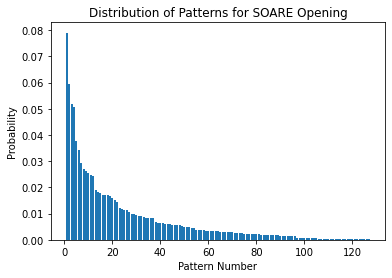

In [86]:
distribution = prob_dist(divide_alphabet('soare', possible_words))
print(f'Expected information gain: {round(entropy(distribution),2)} bits out of 11.18 bits')
distribution.sort(reverse=True)
patterns = list(range(1, len(distribution) + 1))
plt.bar(patterns, distribution)
plt.title('Distribution of Patterns for SOARE Opening')
plt.xlabel('Pattern Number')
plt.ylabel('Probability')
plt.show()

Expected information gain: 4.37 bits out of 11.18 bits


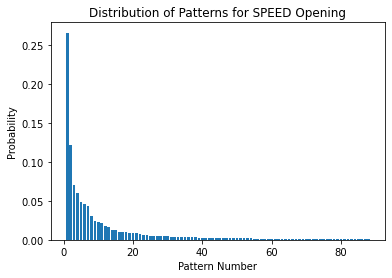

In [87]:
distribution = prob_dist(divide_alphabet('speed', possible_words))
print(f'Expected information gain: {round(entropy(distribution),2)} bits out of 11.18 bits')
distribution.sort(reverse=True)
patterns = list(range(1, len(distribution) + 1))
plt.bar(patterns, distribution)
plt.title('Distribution of Patterns for SPEED Opening')
plt.xlabel('Pattern Number')
plt.ylabel('Probability')
plt.show()

Expected information gain: 1.89 bits out of 11.18 bits


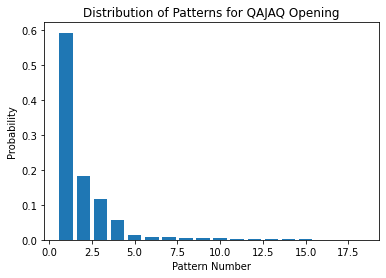

In [88]:
distribution = prob_dist(divide_alphabet('qajaq', possible_words))
print(f'Expected information gain: {round(entropy(distribution),2)} bits out of 11.18 bits')
distribution.sort(reverse=True)
patterns = list(range(1, len(distribution) + 1))
plt.bar(patterns, distribution)
plt.title('Distribution of Patterns for QAJAQ Opening')
plt.xlabel('Pattern Number')
plt.ylabel('Probability')
plt.show()

The "qajaq" opener is so bad that only a few patterns have a positive probability of appearing, which has a very low entropy. Note that the horizontal axis of the last graph is on a different scale from the previous graphs.

**Question:** From how the graphs look, which one has a higher entropy and why? And why does it suggest "soare" is a better opener than "speed"?

**Answer:** The word "soare" has the highest entropy because it matches many words in a variety of patterns, which means the word size associate with possible patterns have a more evenly distribution (in contrast, "qajaq" has a pattern with probability 0.6, which should be "00000" -- few words could be matched with it). "soare" is a better opener because we would gain more information from guessing it.

## Some Useful Optimizations (Read Only)

This part has no implementation that you need to do, but it's highly recommended that you read through this section.

The calculation to find "soare" took a while to run, didn't it? You may realize that the opening guess is always made without any observed pattern, so we don't need to calculate it every time, but can instead save the result that if it's our first guess, we would always return "soare".

Another thing is that now our guesses always come from the huge list of allowed guesses. Suppose that we have now narrowed the alphabet of $X_t$ down to 2 words, "price" and "pride". Guessing a word that isn't in the alphabet, such as "camel", will certainly tell us which one is the correct answer (since it tells us whether there is a "c" in the answer), but we will still need to use a guess to report the correct answer, for a total of 2 additional guesses. However, if we guess a word in the alphabet, not only will it tell us which one of "price" and "pride" is the answer, but also we have a $\frac{1}{2}$ probability to hit it right there so we don't need another guess. Therefore, when the remaining alphabet is small ($\leq 3$), we can instead limit our guesses to within the alphabet.

The following function implements these optimization ideas. Take a look at it to see what's going on.

In [89]:
def find_best_guess_optimized(alphabet):
    if len(alphabet) == 2315:
        # if it's the opening guess, we directly output 'soare'
        return 'soare'
    elif len(alphabet) == 1:
        # if we are certain what the secret word is, directly guess it
        return alphabet[0]
    elif len(alphabet) <= 3:
        # if the alphabet is small, limit our guess to within the alphabet
        return find_best_guess(alphabet, alphabet)
    else:
        # otherwise, we apply no optimization
        return find_best_guess(alphabet, allowed_guesses)

## Performance Test

Let's now sample some secret words and watch our algorithm find the secret word in action! **Implement the function `play_wordle`**, which takes in the true secret word and simulates a Wordle game using our algorithm above.

In [90]:
def create_wordle_game(true_answer):
    def wordle_game(guess):
        # takes in a guess and outputs the pattern
        return pattern_table[guess][true_answer]
    
    return wordle_game

In [91]:
def play_wordle(wordle_game, print_guesses=False):
    alphabet = possible_words
    num_guesses = 0
    while True:
        num_guesses += 1
        guess = find_best_guess_optimized(alphabet)
        color_pattern = wordle_game(guess)
        if print_guesses:
            print(f'Guess {num_guesses}: {guess}  |  Pattern: {color_pattern}')
        if color_pattern == (2, 2, 2, 2, 2):
            # correct answer!
            break
        # TODO: find the true pattern observed, and then update alphabet
        alphabet = divide_alphabet(guess, alphabet)[color_pattern]

    return num_guesses

In [92]:
for _ in range(10):
    true_answer = random.choice(possible_words)
    print('Secret word:', true_answer)
    wordle_game = create_wordle_game(true_answer)
    play_wordle(wordle_game, print_guesses=True)
    print()

Secret word: curry
Guess 1: soare  |  Pattern: (0, 0, 0, 2, 0)
Guess 2: fitch  |  Pattern: (0, 0, 0, 1, 0)
Guess 3: curry  |  Pattern: (2, 2, 2, 2, 2)

Secret word: sauce
Guess 1: soare  |  Pattern: (2, 0, 1, 0, 2)
Guess 2: sauce  |  Pattern: (2, 2, 2, 2, 2)

Secret word: frost
Guess 1: soare  |  Pattern: (1, 1, 0, 1, 0)
Guess 2: acids  |  Pattern: (0, 0, 0, 0, 1)
Guess 3: frost  |  Pattern: (2, 2, 2, 2, 2)

Secret word: await
Guess 1: soare  |  Pattern: (0, 0, 2, 0, 0)
Guess 2: clink  |  Pattern: (0, 0, 1, 0, 0)
Guess 3: await  |  Pattern: (2, 2, 2, 2, 2)

Secret word: glass
Guess 1: soare  |  Pattern: (1, 0, 2, 0, 0)
Guess 2: chals  |  Pattern: (0, 0, 2, 1, 2)
Guess 3: glass  |  Pattern: (2, 2, 2, 2, 2)

Secret word: snare
Guess 1: soare  |  Pattern: (2, 0, 2, 2, 2)
Guess 2: chant  |  Pattern: (0, 0, 2, 1, 0)
Guess 3: snare  |  Pattern: (2, 2, 2, 2, 2)

Secret word: beech
Guess 1: soare  |  Pattern: (0, 0, 0, 0, 1)
Guess 2: denet  |  Pattern: (0, 2, 0, 1, 0)
Guess 3: abaca  |  Patter

Let's take a look at the distribution of the number of guesses needed by sampling 300 secret words. If it takes way too long to run, you can instead sample fewer secret words.

In [67]:
num_guesses = []
num_samples = 300
for true_answer in tqdm(random.sample(possible_words, num_samples)):
    num_guesses.append(play_wordle(create_wordle_game(true_answer)))

100%|██████████| 300/300 [01:14<00:00,  4.01it/s]


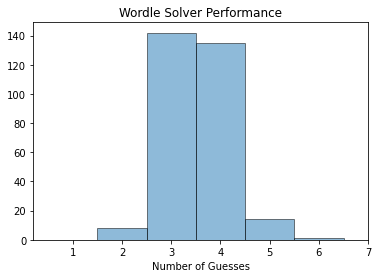

In [68]:
bins = list(range(1, 8))
plt.hist(num_guesses, bins, alpha=0.5, edgecolor='black', align='left')
plt.xlabel('Number of Guesses')
plt.xticks(list(range(1, 8)))
plt.title('Wordle Solver Performance')
plt.show()

If your implementation is correct, your Wordle solver takes fewer guesses on average than American players on average.

In [69]:
print(f'Average number of Wordle guesses using entropy: {round(sum(num_guesses)/num_samples, 3)}')
print('Average number of Wordle guesses for Americans: 3.92')

Average number of Wordle guesses using entropy: 3.527
Average number of Wordle guesses for Americans: 3.92


## Wordle Bot! (Optional)

For the final part of the lab, let's use what we've built so far and transform it into a Wordle bot! **Implement the following class `WordleBot`** that interactively outputs its suggested guess, and receives inputs that consist of your actual guess and the pattern displayed. Feel free to modify the code below to tailor the bot to your liking, such as outputting more than one suggested word, outputting the word along with its mutual information with the secret word, or giving it a better user interface in your personal project!

In [107]:
class WordleBot:
    def __init__(self):
        # initialize for a new game
        self.alphabet = possible_words
        # self.suggest()
    
    def suggest(self):
        # TODO: when called, the bot gives you the best word to guess
        suggested_guess = find_best_guess_optimized(self.alphabet)
        print('Next word to guess:', suggested_guess)
        return suggested_guess
    
    def observe(self, word, pattern):
        # after a guess, feed the pattern to the bot to update
        # then, the bot suggests a word to guess
        assert len(word) == len(pattern) == 5
        # TODO: update self.alphabet according to the observation,
        # then call self.suggest()
        self.alphabet = divide_alphabet(word, self.alphabet)[pattern]
        # self.suggest()
    
    def restart(self):
        # TODO: re-initialize the bot for a new game
        self.alphabet = possible_words
        print('Bot restarted')

In [109]:
# Model the game oop-ly
bot = WordleBot()
for _ in range(4):
    game = create_wordle_game(random.choice(possible_words))
    while True:
        guess = bot.suggest()
        pattern = game(guess)
        if all(x == 2 for x in pattern):
            print("Success")
            bot.restart()
            break
        bot.observe(guess, game(guess))

Next word to guess: soare
Next word to guess: clint
Next word to guess: tacit
Success
Bot restarted
Next word to guess: soare
Next word to guess: feted
Next word to guess: inert
Success
Bot restarted
Next word to guess: soare
Next word to guess: glitz
Next word to guess: amaze
Success
Bot restarted
Next word to guess: soare
Next word to guess: culty
Next word to guess: aband
Next word to guess: tough
Success
Bot restarted
